# Yield

The internal rate of return that will make the present value of the cash flows equal to the price. This is a standard definition of yield but it has a very important 'baked in' assumption that makes it unrealistic. All received cash flows are reinvested at the same rate of return until maturity. So if you held a bond and spent the coupons, 'living off the interest' it would not be accurate to say that you hold a 3% yielding bond. You would have to re-invest each received cash flow at 3% for this to be true. I mentioned this assumption in my first article, a flat or constant yield assumption is an unrealistic but also convenient assumption.

In the previous article we calculated the price of a bond for a given yield, the article concluded with this question- What is the yield of a 5% annual paying coupon that is priced at 112.673, that matures in exactly 5 years from the settlement date?

To value a bond we need to:

1) Identify the cash flow amounts and when we will receive them;

2) Determine the required yield to compensate for the time and risk associated with the cash flows;

3) Discount and sum the future cash flows to find the present value of the bond.

$$ B_{a}=\frac{5}{(1+y)^1}+\frac{5}{(1+y)^2}+\frac{5}{(1+y)^3}+\frac{5}{(1+y)^4}+\frac{105}{(1+y)^5}=112.637 $$

The problem now is that we are not plugging in a single value for the yield, calculating the present value of each cash flow and then summing them to find the value of the bond. If we try and re-arrange this formula to solve for $y$ we will come to the realisation that we are working with a 5th degree polynomial for which there is not a closed-form formula that we can use to build a function in Python. So how are we going to solve for $y$? Guess, of course!

In this first section of code, we are using the same functions as the bond price calculator, the single most important change here is that yield is now a separate input and not an entry in our Bond_Data data frame. For the sake of space, I have also reduced the docstrings of the functions that we previously created. These are still available in this article.

In [2]:
import yearfrac as yf
import matplotlib.pyplot as plt
from collections import namedtuple

# The observed market value of the bond that we are calculating the yield for
price = 112.637

# NOTICE: Bond yield and name is no longer an entry.
Bond_Data = namedtuple("Bond_Data",
                       """ 
                       coupon_schedule, 
                       coupon_rate, 
                       coupon_freq, 
                       face,  
                       prev_coupon""")

corp_5_2026_coupon_schedule = [(2022, 9, 1), 
                                (2023, 9, 1), 
                                (2024, 9, 1), 
                                (2025, 9, 1), 
                                (2026, 9, 1)]

corp_5_2026 = Bond_Data(corp_5_2026_coupon_schedule,
                        0.05,
                        1,
                        100,
                        (2021, 9, 1))

settlement_date = (2021, 9, 1)

def cash_flows(coupon_schedule, 
               coupon_rate, 
               coupon_freq, 
               face):
    """
    This a function which models the cash flows amounts of the bond and 
    outputs a list of nominal cash flows
    """   
    cf = []
    for dates in coupon_schedule:
        cf.append(coupon_rate * face / coupon_freq)
    cf[-1] += face
    return cf

def time_factors(settlement_date, 
                 coupon_schedule, 
                 coupon_freq): 
    """
    This is a function which outputs the time factors for a schedule of 
    coupon payments relative to a single settlement date. 
    Using 30/360 ISDA day count convention.
    """    
    time_factors = []
    
    for dates in coupon_schedule:
        time_factors.append(yf.d30360e(*settlement_date, *dates, matu = False) * coupon_freq)
    return time_factors

def discount_factors(settlement_date, 
                     coupon_schedule, 
                     coupon_freq, 
                     bond_yld):   
    """
    This is a function which calcultes the discount factors which are used to 
    bring nominal cash flows back to present value:
    """  
    tf = time_factors(settlement_date, coupon_schedule, coupon_freq)
    df = []
    
    for factors in tf:
        df.append(1 / (1 + bond_yld / coupon_freq) ** factors )
    return df

def present_value(settlement_date, 
                  coupon_schedule, 
                  coupon_rate, 
                  coupon_freq, 
                  face, 
                  bond_yld):
    """
    This is function which calculates the sum product of the cash_flows 
    and discount_factors function outputs
    """
    
    cf = cash_flows(coupon_schedule, coupon_rate, coupon_freq, face)
    df = discount_factors(settlement_date, coupon_schedule, coupon_freq, bond_yld)
    
    pv_cf = [cf[i] * df[i ] 
             for i in range(len(cf))]
    
    return sum(pv_cf)

def accrued_interest(settlement_date, 
                     coupon_schedule, 
                     coupon_rate, 
                     coupon_freq, 
                     face, 
                     prev_coupon):
    """
    This is a function which calcultes the accrued interest of the bond. 
    Accrured interest is the 'earned' but unpaid interest owed to the 
    bond seller on the settlement date.
    """
    
    full_coupon =  coupon_rate * face / coupon_freq
    accrued_days = yf.d30360e(*prev_coupon, *settlement_date, matu = True) * 360
    days_between_coupon = yf.d30360e(*prev_coupon, *coupon_schedule[0], matu = True) * 360
    accrued_interest =  full_coupon * accrued_days / days_between_coupon
    
    if settlement_date == coupon_schedule[0]:
        return full_coupon
    else: 
        return accrued_interest
    
def bond_price(settlement_date, 
               coupon_schedule, 
               coupon_rate, 
               coupon_freq, 
               face, 
               prev_coupon, 
               bond_yld, 
               clean = True, 
               precision = 6): 
    """
    This is a function which combines the outputs from the functions: 
    present_value and accrued_interest 
    to return either the clean or dirty price fo the bond. 
    By default the function will return the clean price.
    """
    
    dirty_px = present_value(settlement_date, coupon_schedule, coupon_rate, 
                             coupon_freq, face, bond_yld)
    
    ai = accrued_interest(settlement_date, coupon_schedule, coupon_rate, 
                          coupon_freq, face, prev_coupon)
    
    if clean:
        return round(dirty_px - ai, precision)
    else:
        return round(dirty_px, precision)

When you are forced to guess it is always good to first visualise the problem in a graph and identify for which part or/and point we want to solve for. Let's price our bond for a range of interest rates say from 0% to 6%, and then draw a horizontal line to represent the observed price.

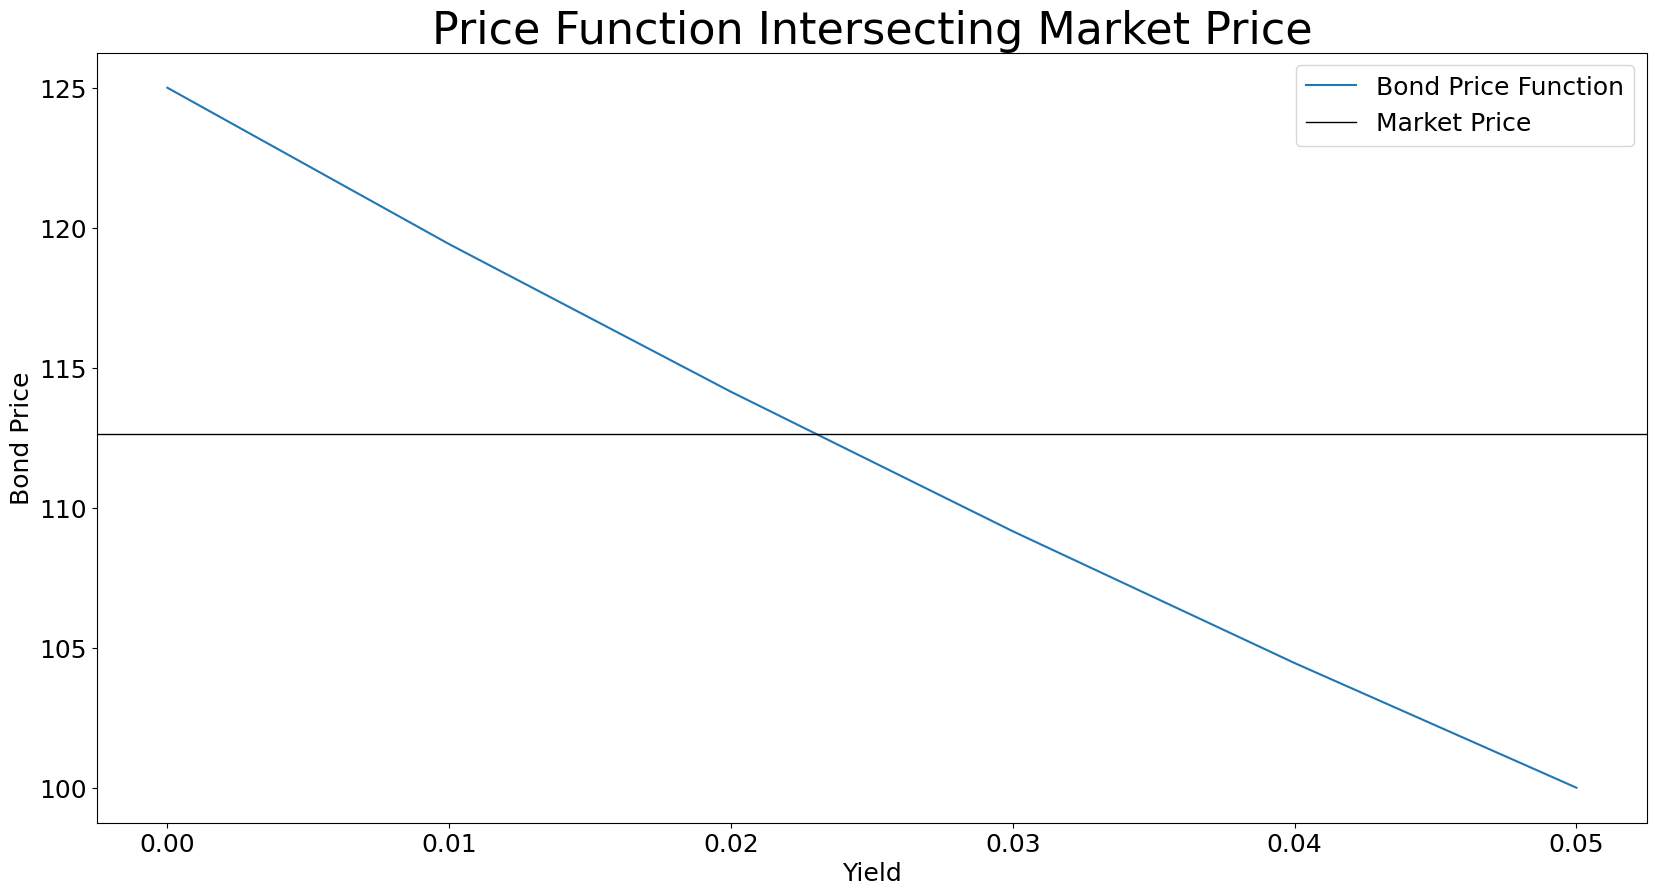

In [3]:
# generate a list of integers from 0 to 5, 
# divide them by 100 to convert them to yields for our bond price function
interest_rates = [i / 100 for i in range(6)]

# a list of bond prices for the yields that we generated above
bond_prices = [bond_price(settlement_date,
                          *corp_5_2026, 
                          i) 
               for i in interest_rates ]

# a chart of our price outputs 
# and a horizontal line for the observed market price of the bond
plt.figure(figsize = (20, 10))
plt.plot(interest_rates, bond_prices, label = "Bond Price Function")
plt.grid(False)
plt.axhline(price, linewidth = 1, label = "Market Price", color = "black")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Yield", fontsize = 18)
plt.ylabel("Bond Price", fontsize = 18)
plt.title("Price Function Intersecting Market Price", fontsize = 32)
plt.legend(fontsize = 18)
plt.show()

So which point on this graph is of interest to us? The point at which our bond price function intersects with the horizontal line, the market price. At this exact point, the yield will return the market price.

How do we find the value of this point on the graph? Eye-balling it, we can see that yield is between 3 and 4%. We need to formulate a trial-and-error process that will help us find the $\text{ytm}$ that satisfies this condition:

$$ \text{PV}(ytm) - \text{Price} = 0 $$

Where $\text{PV}(ytm)$ is our calculated bond price for a given yield and $\text{Price}$ is the observed market price, for intuition we can alternatively refer to $\text{PV}(ytm)$ as the price output of guess value. By setting the equation to zero, the benchmark for our guess is 'dead on'.

Before we proceed let's restructure our graph to better illustrate our goal:

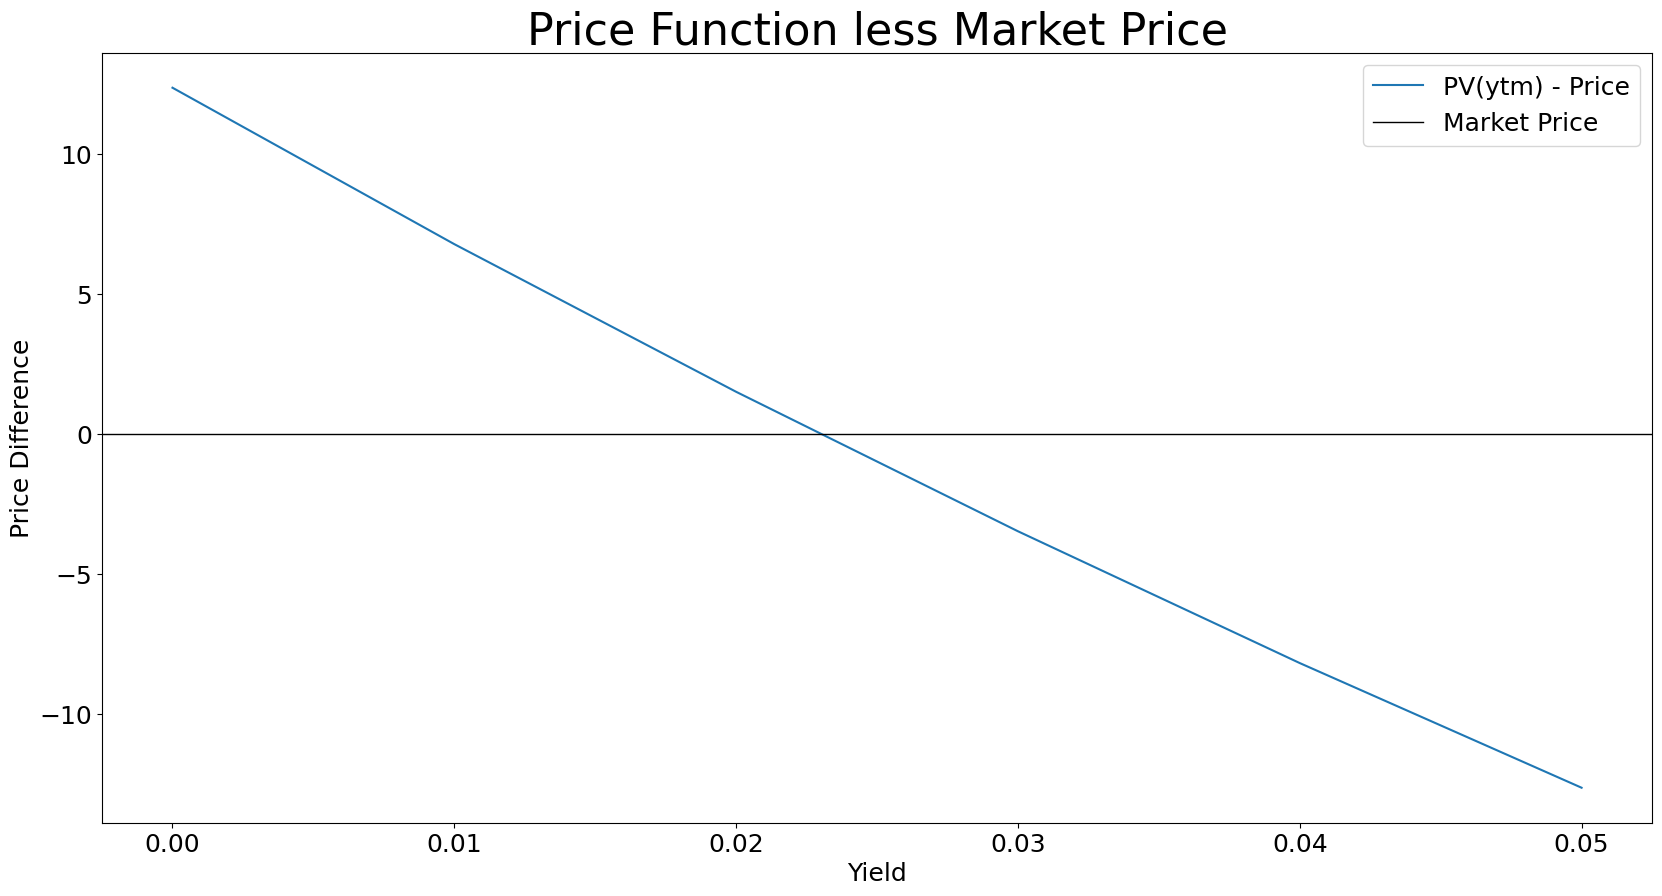

In [4]:
# a list that contains price outputs for a range of yield
#  the observed market price is subtracted from each price output
calc_less_price = [bond_price(settlement_date, 
                              *corp_5_2026, 
                              i) -price 
                   for i in interest_rates]

plt.figure(figsize = (20, 10))
plt.plot(interest_rates, calc_less_price, label = "PV(ytm) - Price")
plt.title("Price Function less Market Price", fontsize = 32)
plt.xlabel("Yield", fontsize = 18)
plt.ylabel("Price Difference", fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.axhline(0, linewidth = 1, label = "Market Price", color = "black")
plt.legend(fontsize = 18)
plt.show()

Our equation is now properly illustrated, and our objective is still the same, find the intersection, but now the line is the price difference between our calculated price and the market price. Mathematically this intersection is known as a root of the function.

$$ \text{PV}(ytm) - \text{Price} = 0 $$

To find the root of our bond price function, or worded more specifically for our problem; To solve for yield we are going to use the Newton-Raphson method. This method is used to approximate the root of a non-linear function by using the derivative of the function. In the first article, we explored the non-linearity of bonds.

## Limit definition of the derivative:

$$\acute f {\left( x_{0} \right)}=\lim_{x_{1} \to x_{0}} \frac{f\left( x_{1} \right)-f\left( x_{0} \right) }{x _{1} - x_{0}}$$

This is calculating the rate of change of the output for a given change in the input at a specific point along the function. The limit notation here then asks "what happens when we make the change in input extremely small? What is the slope at the point where we are making a tiny incremental change?" This is far from a rigid definition of a derivative but I hope it conveys intuition to the reader.

The derivative of a linear function is a constant( $\acute f {\left( x_{0} \right)}$ does not change), this means that the value of the derivative/slope is not dependent on x so we can express the derivative/slope as: 

$$\text{f-linear} \to \acute f {\left( x_{0} \right)}=\frac{f\left( x_{1} \right)-f\left( x_{0} \right) }{x _{1} - x_{0}}$$

To find the root we would then find the value that satisfies:

$$f {\left( x_{1} \right)}= \acute f \left( x_{0} \right)\left(x_{1} -x_{0} \right)+f\left( x_{0} \right)=0$$

Solve for $x_{1}$

$$ x_{1}=x_{0}-\frac{f\left( x_{0} \right)}{\acute f \left( x_{0} \right)} $$

We just said that a bond price function is non-linear, so why are we solving for x in a linear function? The linear function is going to create a tangent line on our plotted bond price function, this line will also intersect the x-axis, not exactly where we need it to solve our original equation but a considerable step towards it. Allow me to first find the derivative of our bond price function and then we will run and graph a couple of guesses before we hand over to our root-finding algorithm.

## Numerical Derivative

Calculus uses the idea of infinitesimally changes to find the derivative which also results in an equation that expresses the derivative, a beautiful process! Instead, we are going to use numerical differentiation, in finance it has the fitting name of 'bump'n re-price'. Remember my poor definition of derivative "What is the slope at the point where we are making a tiny incremental change?". Tiny rather than infinitesimal is exactly what we are going to do!

$$ \acute PV(ytm) = \frac{PV(ytm)-PV(ytm - \text{bump})}{bump} $$

In [5]:
def numerical_derivative(settlement_date, 
                         coupon_schedule, 
                         coupon_rate, 
                         coupon_freq, 
                         face, 
                         prev_coupon, 
                         bond_yld, 
                         bump = .0001):
    
    """
    This function calculates and returns the numerical derivative 
    of a bond by bumping and re-pricing it for the given 'bump' level.
    The function uses a bump of 1 basis point by default.
    
    #INPUTS:
    #settlement_date = Single date value for the date at which the security 
        is exchanged for cash, typically T+1 or T+2, iterable containing: YYYY, MM, DD
    
    #coupon_schedule = The dates of bonds cash flows where the first date is 
        the next coupon date and the last is the maturity of the bond
    
    #coupon_rate = the interest rate paid by the bond, expressed as a decimal value
    
    #coupon_freq = the number of times per year that the bond pays interest
    
    #face =  the par amount of the bond
    
    #bond_yld = The yield at which the bond is being priced
    
    #prev_coupon =  an iterable that contains the date value, YYYY, MM, DD 
        of when the previous coupon was paid
        
    #OUTPUTS:
    # The slope of the bond price function at the given yield
    """
    
    bump_price = bond_price(settlement_date, 
                 coupon_schedule,
                 coupon_rate,
                 coupon_freq, 
                 face, 
                 prev_coupon, 
                (bond_yld - bump))
    
    price = bond_price(settlement_date, 
                 coupon_schedule,
                 coupon_rate,
                 coupon_freq, 
                 face, 
                 prev_coupon, 
                bond_yld)
    
    numerical_derivative = (price - bump_price) / bump
    
    return numerical_derivative

We now have a function that will give us the slope of the tangent line that "just touches" the curve of our bond price function at a given value of x. The equation of the line was:

$$ \acute f {\left( x_{0} \right)}=\frac{f\left( x_{1} \right)-f\left( x_{0} \right) }{x _{1} - x_{0}}$$

re-arranged to solve for $x _{1}$:

$$ x_{1}=x_{0}-\frac{f\left( x_{0} \right)}{\acute f \left( x_{0} \right)} $$

$ \text{where:}$

$ x_{0} =\text{the initial (input) guess} $

$\acute f {\left( x_{0} \right)}=\text{the slope of the bond price function and the tangent line at }x_{0}$

$ f\left( x_{0} \right)=\text{the price of the bond when priced at x_{0}} $

$ x_{1}=\text{our result which is is the next guess value which we will iterate through} $

Let's return to guessing the yield!

From the first graph we could see that the yield is between 2 and 3%. However, we do not want to graph the bond each time, eye-ball the yield to estimate our first guess. We will instead use an initial guess of 0%. So let's calculate the tangent line at $ytm=0%$. I know it is way off but it will actually help demonstrate how fast and beautiful this method is.

You will see in our code below that for $f\left( x_{0} \right)$ that we are also subtracting the observed market price for the bond. Remember, we specified our problem as the differences between our calculated price and the market price. So we can re-write the above equation for $x_{1}$ as:

$$\text{yield}_{1} = \text{yield}_{0}- \frac{\text{PV}(ytm) - \text{Price}}{\acute PV(ytm)}$$

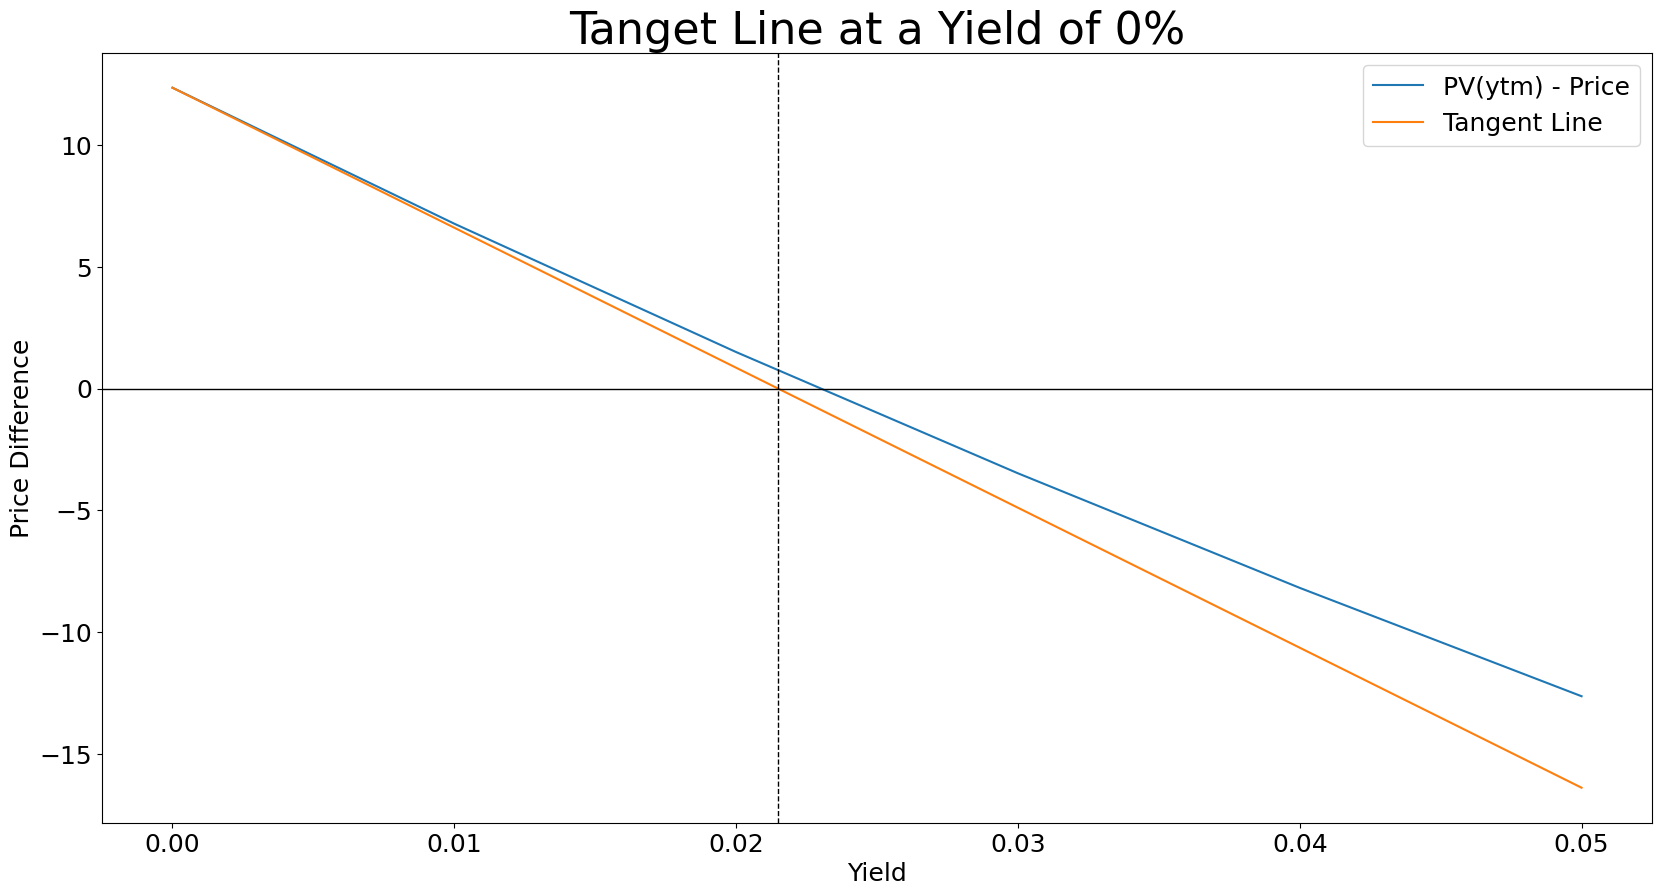

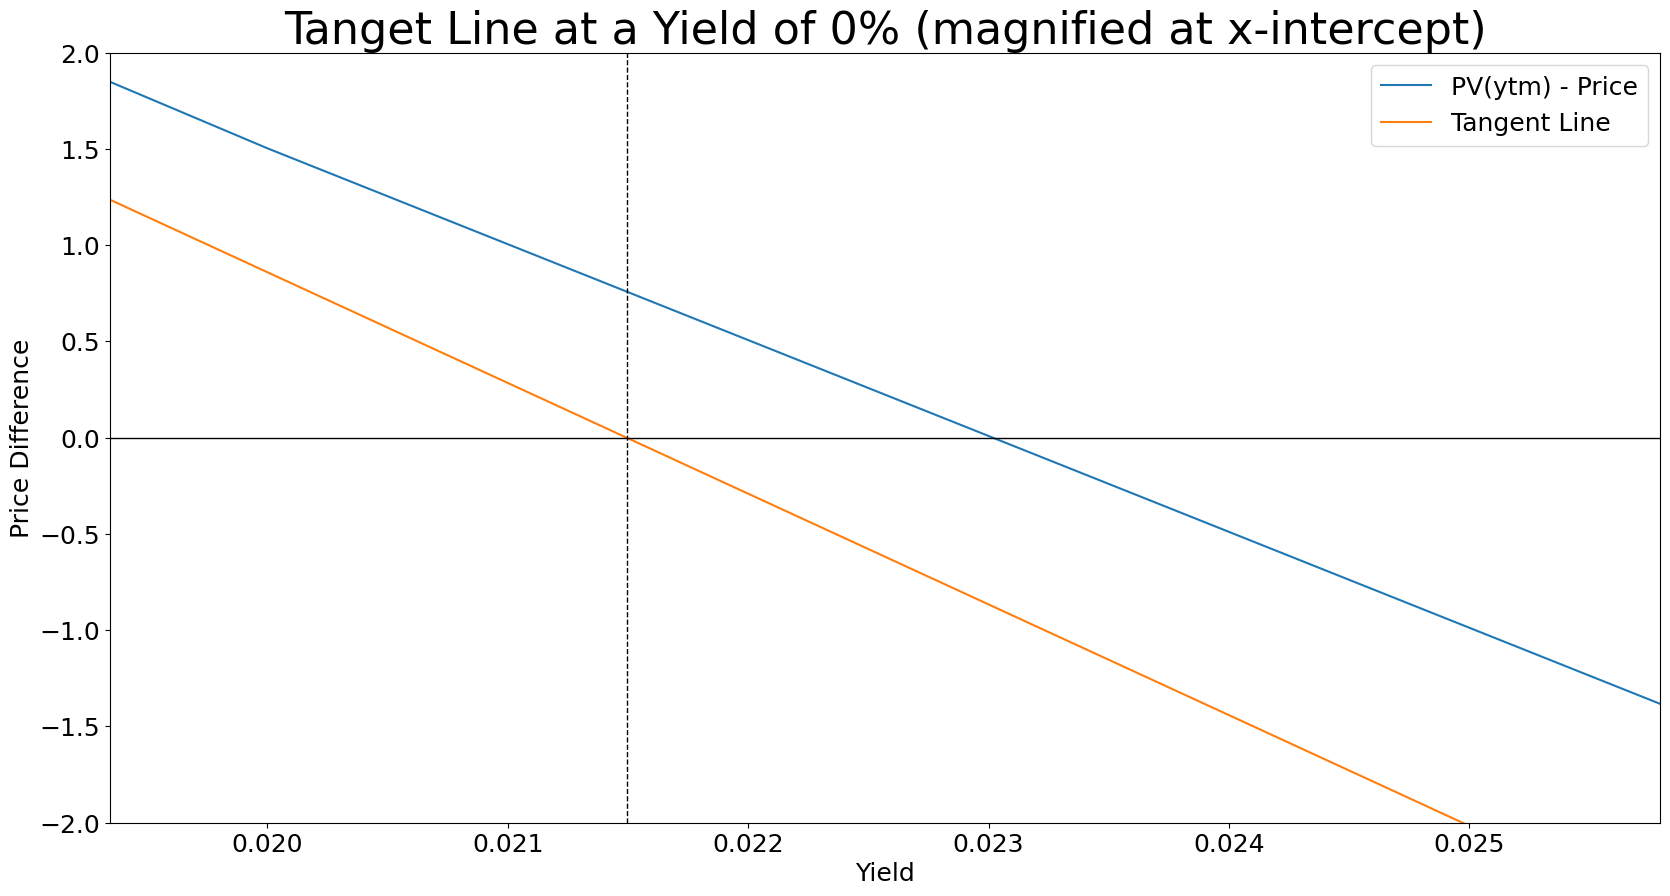

Our first guess is 0% 
which results in price difference of 12.363 
our next guess will be 2.1495%


In [6]:
# Our initial guess
x_zero = 0

# Calculate the slope of our tangent line that will have the same slope as
# our bond function at x_zer0
num_der1 = numerical_derivative(settlement_date, 
                                *corp_5_2026, 
                                x_zero)

# Calculate values to graph the tangent line
tangent1 = [bond_price(settlement_date, 
                       *corp_5_2026,  
                       x_zero) - price + i * num_der1  
            for i in interest_rates]


# The values that we need for our ratio to calculate our next guess
numerator = bond_price(settlement_date, *corp_5_2026, x_zero) - price

denominator = numerical_derivative(settlement_date, 
                                   *corp_5_2026, 
                                   x_zero)

# x_one is the output of this iteration, our next guess
x_one = x_zero - numerator / denominator

# Chart 1
plt.figure(figsize = (20, 10))
plt.title(f"Tanget Line at a Yield of {round(x_zero * 100,4)}%", fontsize = 32)
plt.plot(interest_rates, calc_less_price, label = "PV(ytm) - Price")
plt.plot(interest_rates, tangent1, label = "Tangent Line")
plt.axhline(0, linewidth = 1, color="black")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Yield", fontsize = 18)
plt.ylabel("Price Difference", fontsize = 18)
plt.axvline(x_one, linewidth = 1, linestyle = "--", color = "black")
plt.legend(fontsize = 18)
plt.show()

# Chart 2
plt.figure(figsize = (20, 10))
plt.title(f"Tanget Line at a Yield of {round(x_zero * 100, 4)}% (magnified at x-intercept)", fontsize = 32)
plt.plot(interest_rates, calc_less_price, label = "PV(ytm) - Price")
plt.plot(interest_rates, tangent1, label = "Tangent Line")
plt.axhline(0, linewidth = 1, color="black")
plt.axvline(x_one, linewidth = 1, linestyle = "--", color = "black")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Yield", fontsize = 18)
plt.ylabel("Price Difference", fontsize = 18)
plt.xlim(x_one * 0.9, x_one * 1.2)
plt.ylim(-2,2)
plt.legend(fontsize = 18)
plt.show()

# String formatting for our print statement 
result = """Our first guess is {a}% 
which results in price difference of {b} 
our next guess will be {c}%""".format(
    a = round(x_zero,6) * 100, 
    b = round(numerator, 6) , 
    c = round(x_one, 6) * 100)

print(result)

The point where the tangent line intercept the x-axis is now our $x_{1}$, our new initial guess value in the next iteration of the same process. Before we jump into the next iteration, take a moment to appreciate how close a wild guess of 0% got us to the target intercept.

Repeating the same process but now $x_{1}$ is our initial guess

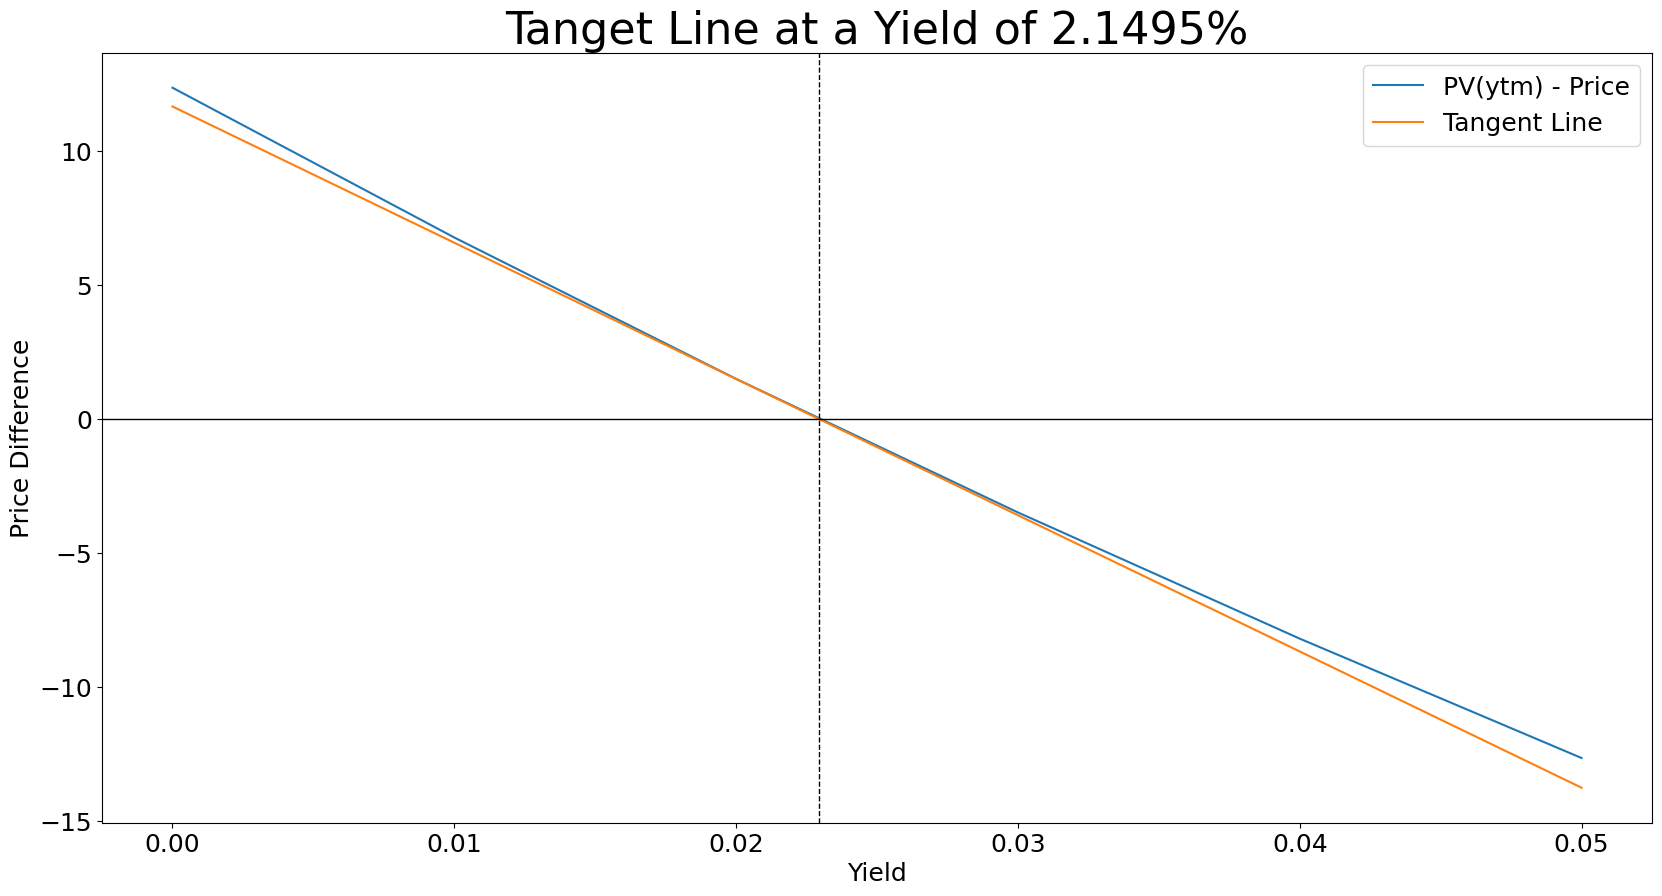

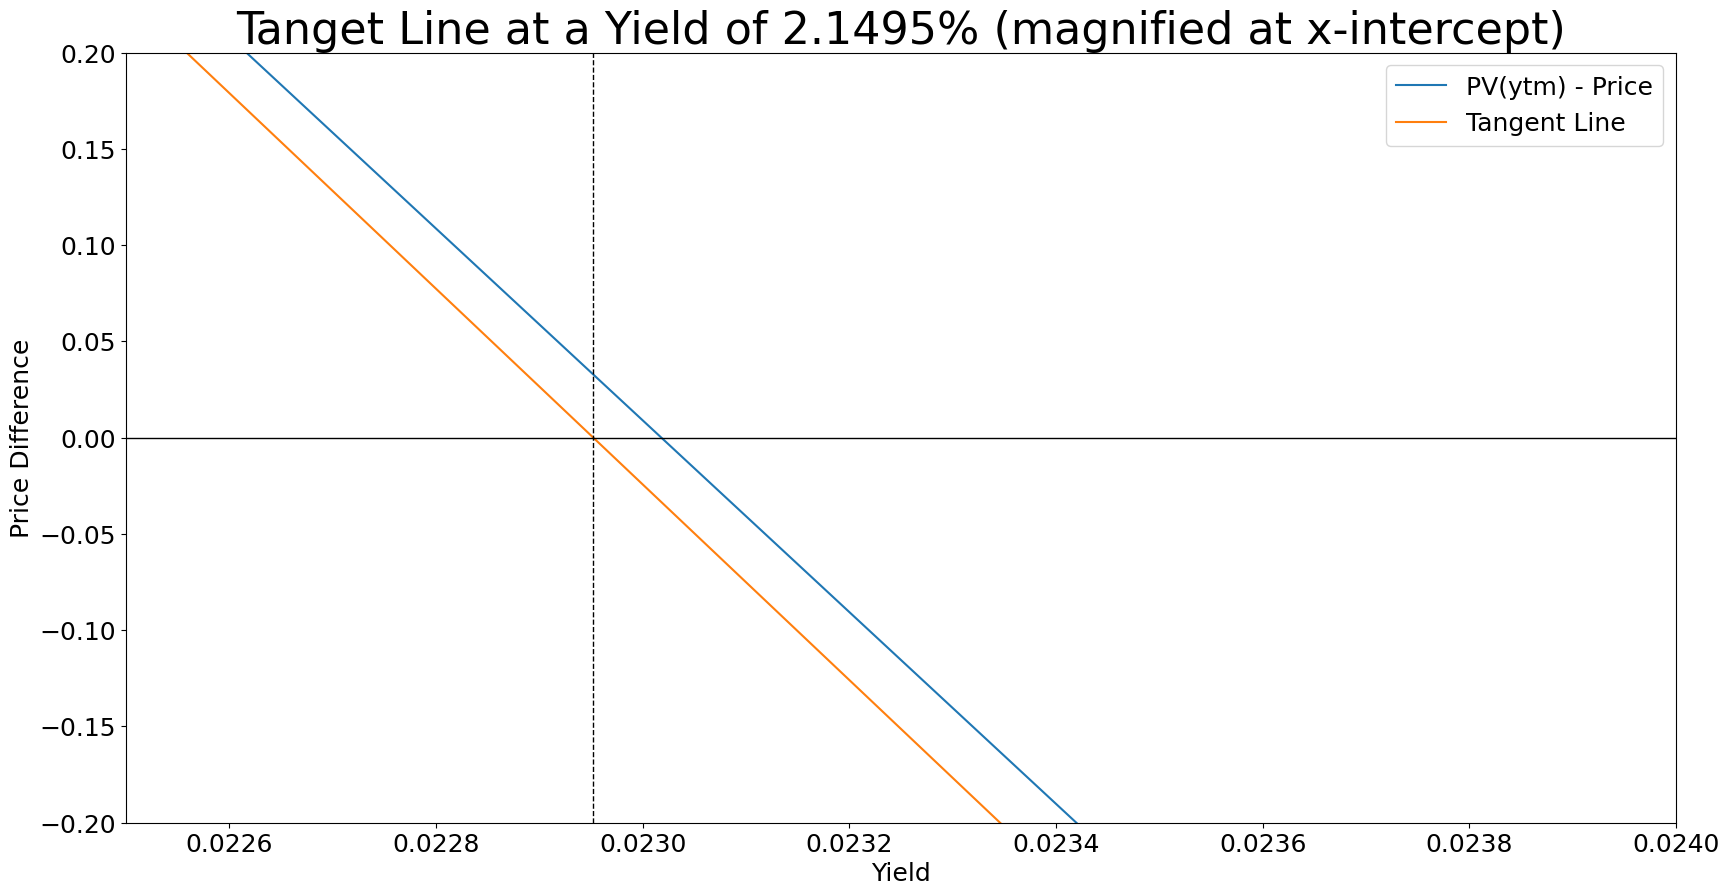

Our second guess is 2.1495% 
which results in price difference of 0.740863 
our next guess will be 2.295239%


In [29]:
# x_one is now our input yield, for the derivative
num_der2 = numerical_derivative(settlement_date, *corp_5_2026, x_one)

# Calculate values to graph the tangent line
tangent2 = [bond_price(settlement_date, 
                       *corp_5_2026, 
                       x_one) - price + (i- x_one) * num_der2 
            for i in interest_rates]

# The values that we need for our ratio to calculate our next guess
numerator = bond_price(settlement_date, *corp_5_2026, x_one) - price

denominator = num_der2

x_two = x_one - numerator / denominator

# Chart 1
plt.figure(figsize = (20, 10))
plt.title(f"Tanget Line at a Yield of {round(x_one * 100,4)}%", fontsize = 32)
plt.plot(interest_rates, calc_less_price, label = "PV(ytm) - Price")
plt.plot(interest_rates, tangent2, label = "Tangent Line")
plt.axhline(0, linewidth = 1, color="black")
plt.axvline(x_two, linewidth = 1, linestyle = "--", color = "black")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Yield", fontsize = 18)
plt.ylabel("Price Difference", fontsize = 18)
plt.legend(fontsize = 18)
plt.show()

# Chart 2
plt.figure(figsize = (20, 10))
plt.title(f"Tanget Line at a Yield of {round(x_one * 100, 4)}% (magnified at x-intercept)", fontsize = 32)
plt.plot(interest_rates, calc_less_price, label = "PV(ytm) - Price")
plt.plot(interest_rates, tangent2, label = "Tangent Line")
plt.axhline(0, linewidth = 1, color="black")
plt.axvline(x_two, linewidth = 1, linestyle = "--", color = "black")
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel("Yield", fontsize = 18)
plt.ylabel("Price Difference", fontsize = 18)
plt.xlim(0.0225,0.024)
plt.ylim(-0.2,0.2)
plt.legend(fontsize = 18)
plt.show()

# String formatting for our print statement 
result = """Our second guess is {a}% 
which results in price difference of {b} 
our next guess will be {c}%""".format(
    a = round(x_one,6) * 100, b = round(numerator, 6) , c = round(x_two * 100, 6) )

print(result)

So the second guess, which started from a wild huch of 0% as already got us within less than a bond point. Instead of repeating the entire process for the guess output, let us immediately plug our latest guess value into our bond price formula and see how close we are:

In [433]:
price_diff = bond_price(settlement_date, *corp_5_2026, x_two) - price

result = """Using the resulting yield after two iterations is: {a}%
This results in a price difference of {b}""".format(
    a = round(x_two*100,4), b = round(price_diff, 6))

print(result)

Using the resulting yield after two iterations is: 2.2881%
This results in a price difference of 0.002965


Iterating through this process twice as resulted in an approximate yield that gets us to a price that is within $0.003$.

That was a substantial amount of code and graphs to apply and illustrate a step-by-step application of Newton-Raphsons method, but as always, I hope it has given the reader intuition for how the method works. We will now construct a function that does all this work for us.

In [410]:
price = 112.673267

def bond_yield(settlement_date, 
               coupon_schedule, 
               coupon_rate, 
               coupon_freq, 
               face, 
               prev_coupon, 
               price, 
               precision = 6, 
               show_stats = False):
    """
    This function calculates and returns the yield of a bond. It has the
    option to display the number of guesses and each respected guessed value. 
    By default the guess stats are not show. The user can also select to 
    whichlevel of precision in the price difference that the yield should 
    be calculated to, default is six.
    
    #INPUTS:
    #settlement_date = Single date value for the date at which the security 
        is exchanged for cash, typically T+1 or T+2, iterable containing: YYYY, MM, DD
    
    #coupon_schedule = The dates of bonds cash flows where the first date is 
        the next coupon date and the last is the maturity of the bond
    
    #coupon_rate = the interest rate paid by the bond, expressed as a decimal value
    
    #coupon_freq = the number of times per year that the bond pays interest
    
    #face =  the par amount of the bond
    
    #bond_yld = The yield at which the bond is being priced
    
    #prev_coupon =  an iterable that contains the date value, YYYY, MM, DD 
        of when the previous coupon was paid
        
     OUTPUTS:
    #The yield of the bond. If show_stats is set to True then the number of
    guesses and guess values will also be printed.
    """
    
    yld = 0 # the first initial guess value
    n = 0 # counter for number of iterations
    
    # as long as the absolute rounded price difference is greater than zero
    # keep itererating through guesses
    while abs(round(bond_price(settlement_date, 
                               coupon_schedule, 
                               coupon_rate, 
                               coupon_freq, 
                               face, 
                               prev_coupon, 
                               yld, 
                               precision = 
                               precision) - price, 6)) > 0:
        
        # incremented for each guess
        n += 1
       
        # the bond price output using the guessed yield
        estimated_price = bond_price(settlement_date, 
                                     coupon_schedule, 
                                     coupon_rate, 
                                     coupon_freq, 
                                     face, 
                                     prev_coupon, 
                                     yld)
        
        # the derivative/slope of the bond price function at our guess yield
        derivative = numerical_derivative(settlement_date, 
                                          coupon_schedule, 
                                          coupon_rate, 
                                          coupon_freq, 
                                          face, 
                                          prev_coupon, 
                                          yld)
        
        # the equation that calculates the next and closer guess input
        yld = yld - (estimated_price - price) / derivative
        
        # returns a print statement for each guess and it's output
        if show_stats == True:
            print(f"guess{n}: {round(yld, precision) * 100} %")
    
    # once the absolute rounded price difference is zero 
    # we calculate the price at this yield level
    check_price = bond_price(settlement_date, 
                             coupon_schedule, 
                             coupon_rate, 
                             coupon_freq, 
                             face, 
                             prev_coupon, 
                             yld)
    
    # Summary print statement if user has selected to show stats
    if show_stats == True:
        
        print(f"This function estimated the bond yield within {precision} decimal places using a total of {n} guesses")
        
        print(f"The price difference at this yield is : {check_price - price}")
        
        return yld
    
    else:
        
        return yld

bond_yield(settlement_date, *corp_5_2026, price, precision = 12, show_stats = True)

guess1: 2.1431460263999997 %
guess2: 2.2880473778 %
guess3: 2.2886903766 %
guess4: 2.2886905749 %
This function estimated the bond yield within 12 decimal places using a total of 4 guesses
The price difference at this yield is : 0.0


0.02288690574921828

We can now calculate the yield given the price of the bond. What about comparing the yield of two different bonds? Is yield a comparable return measure that we can use for security selection? 

Your holding period is one year and this is your interest rate environment(curve):

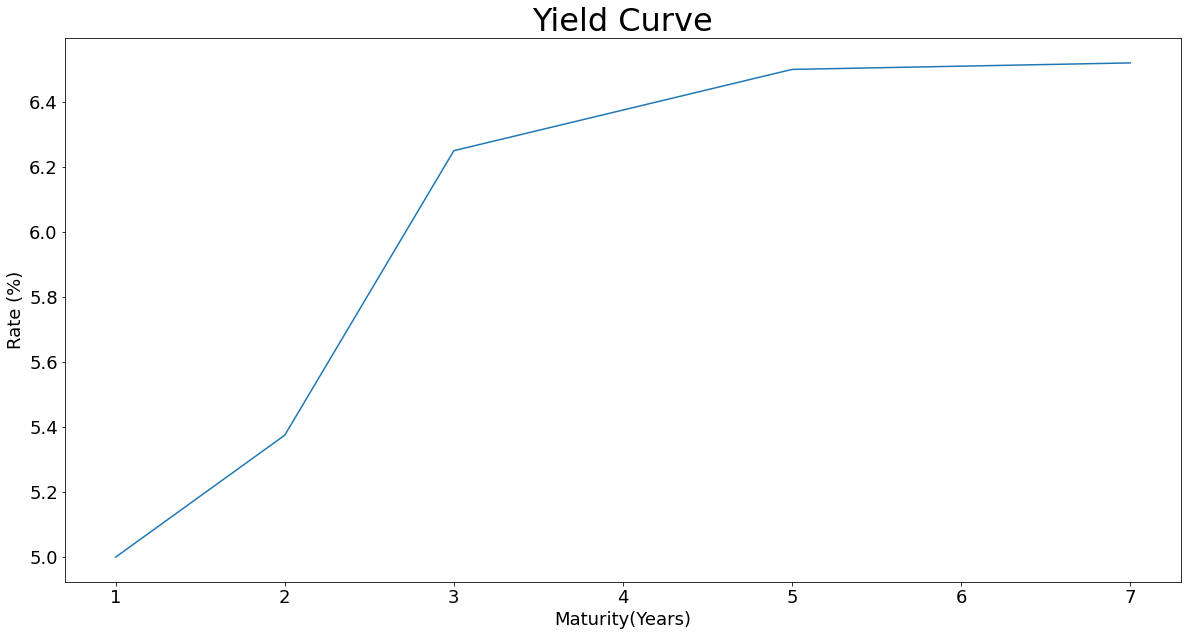

In [411]:
t = list(range(1,8))
i = [5.0, 5.375, 6.25, 6.375, 6.5, 6.51, 6.52]

plt.figure(figsize = (20, 10))
plt.plot(t, i)
plt.title("Yield Curve", fontsize = 32)
plt.xlabel("Maturity(Years)", fontsize = 18)
plt.ylabel("Rate (%)", fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

You have the choice of these two bonds, your expectation is that interest rates will not change during your holding period. Which bond do you buy today and sell in one year?

| Bond  |  Maturity | Coupon  | Price | Yield  |
|:-:|---|---|---|---|
|  A | 3-year  | 6%  | 99.33  | 6.25%  |
|  B |  7-year |  6% |  97.15 | 6.52%  |